In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from urllib.parse import urlparse
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data=pd.read_csv('dummy.csv')

In [5]:
data.head()

,text,url,description,homepage_url
0,Shopify Store Development Experts,https://usa.adrevu.com/classified.php?citycoun...,Description: Transform your business with our ...,https://infostans.com/shopify-development/
1,Revive Your Energy with NAD+ Injections – Your...,https://usa.adrevu.com/classified.php?citycoun...,"Description: ""Experience a surge in energy and...",https://ivyrx.com/products/nad-injection
2,Buy Online Abortion Pill Pack At Affordable P...,https://usa.adrevu.com/classified.php?citycoun...,Description: Buy online abortion pill pack at ...,https://www.abortionprivacy.com/abortion-pill-...
3,2 Beautiful littleyorkie puppies {male and fem...,https://usa.adrevu.com/classified.php?citycoun...,Description: 2 Beautiful littleyorkie puppies ...,http://
4,How to Choose the Right WooCommerce Developmen...,https://usa.adrevu.com/classified.php?citycoun...,Description: A WooCommerce Development Company...,https://infostans.com/woocommerce-development/


In [6]:
# Text cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower().strip()

In [7]:

# Clean text
data['text'] = data['text'].apply(clean_text)
data['description'] = data['description'].apply(clean_text)

In [8]:
# Feature extraction
data['text_length'] = data['text'].apply(len)
data['description_length'] = data['description'].apply(len)
data['url_length'] = data['url'].apply(len)

In [9]:
# Text vectorization
tfidf = TfidfVectorizer(max_features=100)
text_tfidf = tfidf.fit_transform(data['text'] + ' ' + data['description'])
tfidf_df = pd.DataFrame(text_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [10]:
# Combine features
features = pd.concat([data[['text_length', 'description_length', 'url_length']], tfidf_df], axis=1)


In [11]:
data.head()

,text,url,description,homepage_url,text_length,description_length,url_length
0,shopify store development experts,https://usa.adrevu.com/classified.php?citycoun...,description transform your business with our e...,https://infostans.com/shopify-development/,33,378,64
1,revive your energy with nad injections your p...,https://usa.adrevu.com/classified.php?citycoun...,description experience a surge in energy and w...,https://ivyrx.com/products/nad-injection,66,217,64
2,buy online abortion pill pack at affordable pr...,https://usa.adrevu.com/classified.php?citycoun...,description buy online abortion pill pack at a...,https://www.abortionprivacy.com/abortion-pill-...,50,254,64
3,2 beautiful littleyorkie puppies male and female,https://usa.adrevu.com/classified.php?citycoun...,description 2 beautiful littleyorkie puppies m...,http://,48,474,63
4,how to choose the right woocommerce developmen...,https://usa.adrevu.com/classified.php?citycoun...,description a woocommerce development company ...,https://infostans.com/woocommerce-development/,55,323,64


In [26]:
features.shape

(126, 103)

In [12]:
# Normalize numerical features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [13]:
# PCA dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [16]:
# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_pca)


KMeans(n_clusters=2, random_state=42)

In [17]:
# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(features_pca)

IsolationForest(contamination=0.1, random_state=42)

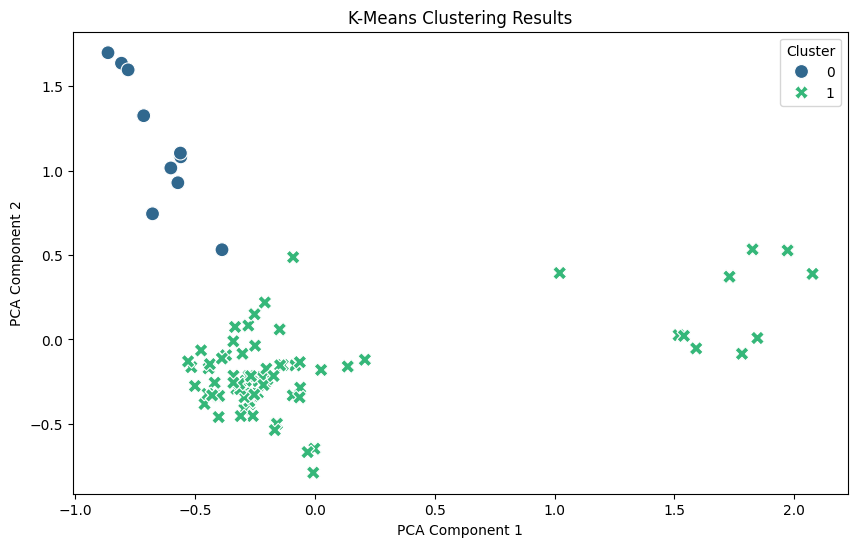

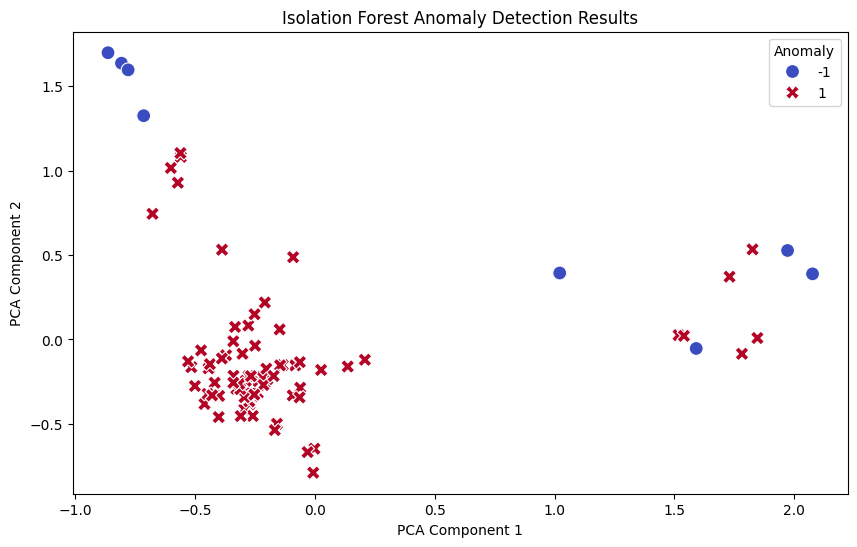

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `features_pca` contains the PCA-transformed data
# And `kmeans.labels_` gives the cluster labels from K-Means
# `iso_forest` can provide the anomaly labels

# Convert PCA results to a DataFrame for easier plotting
pca_df = pd.DataFrame(features_pca, columns=['PCA1', 'PCA2'])

# Add the K-Means cluster labels to the DataFrame
pca_df['Cluster'] = kmeans.labels_

# Add the Isolation Forest anomaly labels (1 for normal, -1 for anomaly)
pca_df['Anomaly'] = iso_forest.predict(features_pca)

# Plotting the clusters with K-Means labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', style='Cluster', s=100)
plt.title('K-Means Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Plotting the clusters with Isolation Forest anomaly detection
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Anomaly', palette='coolwarm', style='Anomaly', s=100)
plt.title('Isolation Forest Anomaly Detection Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Anomaly')
plt.show()


# Prediction function  

In [18]:
def predict_new_ad(new_ad, tfidf, scaler, pca, kmeans, iso_forest):
    # Preprocess the text fields
    new_ad_cleaned_text = clean_text(new_ad['text'])
    new_ad_cleaned_description = clean_text(new_ad['description'])
    
    # Process the URLs
    new_ad_domain = urlparse(new_ad['url']).netloc
    new_ad_homepage_domain = urlparse(new_ad['homepage_url']).netloc
    
    # Calculate length features
    text_length = len(new_ad_cleaned_text)
    description_length = len(new_ad_cleaned_description)
    url_length = len(new_ad['url'])
    
    # Vectorize text
    text_vector = tfidf.transform([new_ad_cleaned_text + ' ' + new_ad_cleaned_description])
    text_vector_df = pd.DataFrame(text_vector.toarray(), columns=tfidf.get_feature_names_out())
    
    # Combine length and text features
    new_ad_features = pd.DataFrame({
        'text_length': [text_length],
        'description_length': [description_length],
        'url_length': [url_length]
    })
    new_ad_features_combined = pd.concat([new_ad_features, text_vector_df], axis=1)
    
    # Scale the features
    new_ad_features_scaled = scaler.transform(new_ad_features_combined)
    
    # Apply PCA for dimensionality reduction
    new_ad_pca = pca.transform(new_ad_features_scaled)
    
    # Predict using K-Means clustering
    cluster_label = kmeans.predict(new_ad_pca)
    
    # Predict using Isolation Forest
    anomaly_label = iso_forest.predict(new_ad_pca)
    
    # Determine if the ad is likely fake
    is_fake = (cluster_label == 0) & (anomaly_label == -1)
    
    return is_fake, cluster_label, anomaly_label

In [19]:
new_ad = {
    'text': "Buy cheap products now!",
    'description': "Discounts on various items. Limited time offer.",
    'url': "http://example-fake-site.com/sale",
    'homepage_url': "http://example-fake-site.com"
}

is_fake, cluster_label, anomaly_label = predict_new_ad(new_ad, tfidf, scaler, pca, kmeans, iso_forest)

if is_fake:
    print("The ad is likely fake.")
else:
    print("The ad is likely genuine.")

The ad is likely genuine.
